<a href="https://colab.research.google.com/github/nduas77/AIPND_image_classification/blob/master/Hehe_4_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Udacity PyTorch Scholarship Final Lab Challenge

**By [nduati(Kaggle - nduas77)](https://www.linkedin.com/in/nduas77)**

In [1]:
!pip install --no-cache-dir -I pillow

    100% |████████████████████████████████| 2.0MB 33.6MB/s 


In [0]:
#!wget 'https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip'
#!unzip flower_data.zip

In [0]:
# http://pytorch.org/
#from os.path import exists
#from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
#platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
#cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
#accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
#import torch
#!pip install torch==0.4.0 torchvision

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import numpy as np

In [0]:
data_dir = 'flower_data'

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/valid', transform=test_transforms)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [6]:
model = models.densenet161(pretrained=True)

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [7]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(2208, 1024)),
    ('relu', nn.ReLU()),
    ('dropout', nn.Dropout(0.4)),
    ('fc2', nn.Linear(1024, 102)),
    ('output', nn.LogSoftmax(dim=1))
]))
    
model.classifier = classifier
model.classifier

Sequential(
  (fc1): Linear(in_features=2208, out_features=1024, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.4)
  (fc2): Linear(in_features=1024, out_features=102, bias=True)
  (output): LogSoftmax()
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [9]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
epochs = 50

valid_loss_min = np.Inf

# Some lists to keep track of loss and accuracy during each epoch
epoch_list = []
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []
# Start epochs
for epoch in range(epochs):
    
    #adjust_learning_rate(optimizer, epoch)
    
    # monitor training loss
    train_loss = 0.0
    val_loss = 0.0
    
    ###################
    # train the model #
    ###################
    # Set the training mode ON -> Activate Dropout Layers
    model.train() # prepare model for training
    # Calculate Accuracy         
    correct = 0
    total = 0
    
    # Load Train Images with Labels(Targets)
    for data, target in train_loader:
        
        if train_on_gpu:
            data, target = data.to(device), target.to(device)
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        
        if type(output) == tuple:
            output, _ = output
        
        # Calculate Training Accuracy 
        predicted = torch.max(output.data, 1)[1]        
        # Total number of labels
        total += len(target)
        # Total correct predictions
        correct += (predicted == target).sum()
        
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
    
    # calculate average training loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)
    
    # Avg Accuracy
    accuracy = 100 * correct / float(total)
    
    # Put them in their list
    train_acc_list.append(accuracy)
    train_loss_list.append(train_loss)
    
        
    # Implement Validation like K-fold Cross-validation 
    
    # Set Evaluation Mode ON -> Turn Off Dropout
    model.eval() # Required for Evaluation/Test

    # Calculate Test/Validation Accuracy         
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:


            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Predict Output
            output = model(data)
            if type(output) == tuple:
                output, _ = output

            # Calculate Loss
            loss = criterion(output, target)
            val_loss += loss.item()*data.size(0)
            # Get predictions from the maximum value
            predicted = torch.max(output.data, 1)[1]

            # Total number of labels
            total += len(target)

            # Total correct predictions
            correct += (predicted == target).sum()
    
    # calculate average training loss and accuracy over an epoch
    val_loss = val_loss/len(test_loader.dataset)
    accuracy = 100 * correct/ float(total)
    
    # Put them in their list
    val_acc_list.append(accuracy)
    val_loss_list.append(val_loss)
    
    # Print the Epoch and Training Loss Details with Validation Accuracy   
    print('Epoch: {} \tTraining Loss: {:.4f}\t Val. acc: {:.2f}%'.format(
        epoch+1, 
        train_loss,
        accuracy
        ))
    # save model if validation loss has decreased
    if val_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        val_loss))
        # Save Model State on Checkpoint
        torch.save(model.state_dict(), 'umodel.pt')
        valid_loss_min = val_loss
    # Move to next epoch
    epoch_list.append(epoch + 1)

Epoch: 1 	Training Loss: 3.0012	 Val. acc: 76.00%
Validation loss decreased (inf --> 1.150416).  Saving model ...
Epoch: 2 	Training Loss: 1.1652	 Val. acc: 89.00%
Validation loss decreased (1.150416 --> 0.536424).  Saving model ...
Epoch: 3 	Training Loss: 0.7704	 Val. acc: 91.00%
Validation loss decreased (0.536424 --> 0.382065).  Saving model ...
Epoch: 4 	Training Loss: 0.6249	 Val. acc: 93.00%
Validation loss decreased (0.382065 --> 0.306825).  Saving model ...
Epoch: 5 	Training Loss: 0.5344	 Val. acc: 93.00%
Validation loss decreased (0.306825 --> 0.294475).  Saving model ...
Epoch: 6 	Training Loss: 0.4904	 Val. acc: 94.00%
Validation loss decreased (0.294475 --> 0.239530).  Saving model ...
Epoch: 7 	Training Loss: 0.4554	 Val. acc: 93.00%
Validation loss decreased (0.239530 --> 0.232669).  Saving model ...
Epoch: 8 	Training Loss: 0.4310	 Val. acc: 92.00%
Epoch: 9 	Training Loss: 0.4010	 Val. acc: 92.00%
Epoch: 10 	Training Loss: 0.3874	 Val. acc: 94.00%
Validation loss decre

## Links Here:  
**Model State Checkpoint File: [umodel.pt](./umodel.pt)**   (Preferred)  

In [0]:
#model.load_state_dict(torch.load('gdrive/My Drive/umodelscheduler.pt'))

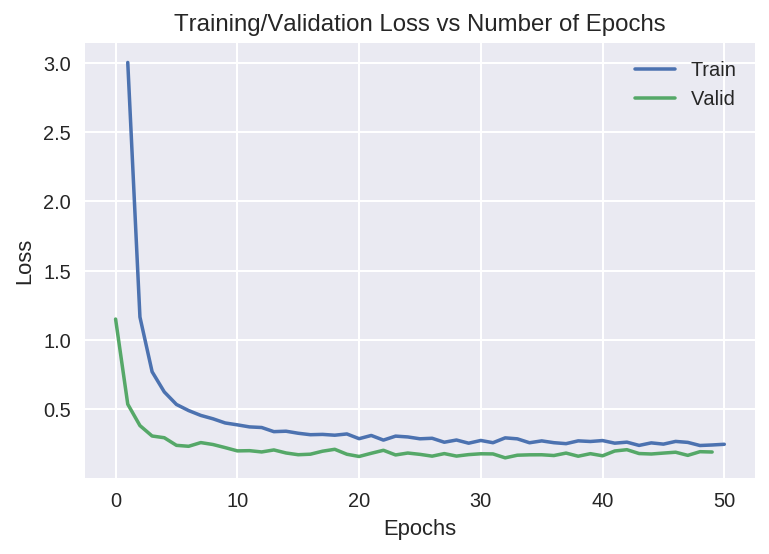

In [12]:
# Training / Validation Loss
plt.plot(epoch_list,train_loss_list)
plt.plot(val_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training/Validation Loss vs Number of Epochs")
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()

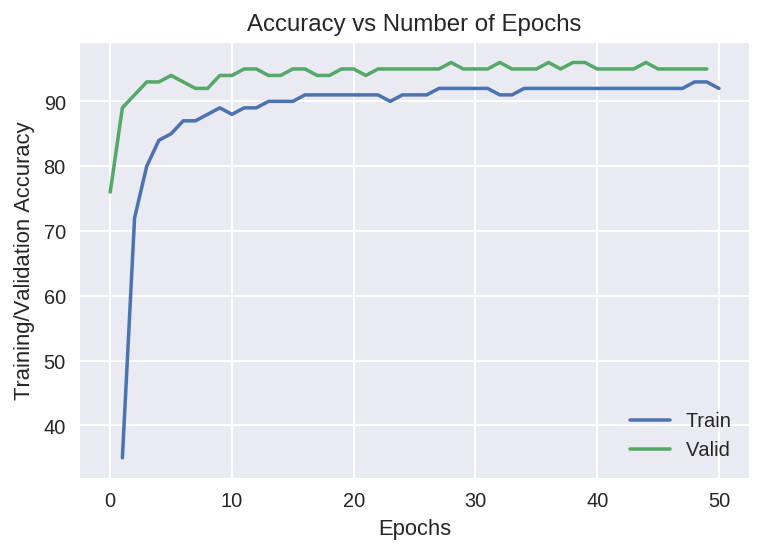

In [13]:
# Train/Valid Accuracy
plt.plot(epoch_list,train_acc_list)
plt.plot(val_acc_list)
plt.xlabel("Epochs")
plt.ylabel("Training/Validation Accuracy")
plt.title("Accuracy vs Number of Epochs")
plt.legend(['Train', 'Valid'], loc='best')
plt.show()

In [14]:
val_acc = sum(val_acc_list[:]).item()/len(val_acc_list)
print("Validation Accuracy of model = {} %".format(val_acc))

Validation Accuracy of model = 94.14 %


In [15]:
!git clone https://github.com/GabrielePicco/deep-learning-flower-identifier
!pip install airtable
import sys
sys.path.insert(0, 'deep-learning-flower-identifier')

Cloning into 'deep-learning-flower-identifier'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 71 (delta 40), reused 31 (delta 4), pack-reused 0
Unpacking objects: 100% (71/71), done.
  Running setup.py bdist_wheel for airtable ... - done
  Stored in directory: /root/.cache/pip/wheels/9b/ba/63/364c02fabcd50ef6e2f101a57feb727bd7a693697765a9df17
Successfully built airtable


In [16]:
import sys
sys.path.insert(0, 'deep-learning-flower-identifier')
from test_model_pytorch_facebook_challenge import calc_accuracy
calc_accuracy(model, input_image_size=224, use_google_testset=False)

100.0% 35053568 / 35050314


Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 0.90625
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 0.875
Batch accuracy (Size 32): 0.9375
Batch accuracy (Size 32): 0.9375
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 0.9375
Batch accuracy (Size 32): 0.9375
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 0.9375
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 0.9375
Batch accuracy (Size 32): 0.9473684430122375
Mean accuracy: 0.9667257070541382


0.9667257